# PopulationSim validation script

## Inputs

This script accepts several
A YAML with region-specific parameters

### argv[2]: csv_file (optional)
A CSV with paths to the following directories
- POPSIMDIR
- VALID_DIR

## Import packages

In [1]:
import os
import sys
try:
    import yaml
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    packages = 'pyyaml pandas numpy matplotlib'
    ret = os.system(f'conda install {packages}')
    if ret != 0:
        os.system(f'pip install {packages}')

## Configure matplotlib

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (5,10)
plt.rcParams['hist.bins'] = 25

## Load input parameters

In [29]:
parameters = {}
region_yaml = 'tulare_region.yaml'  # default

# ignore sys.argv if running validation notebook
is_script = 'ipykernel' not in sys.modules

if is_script and len(sys.argv) > 1:
    if os.path.isfile(sys.argv[1]):
        region_yaml = sys.argv[1]

with open(region_yaml) as f:
    parameters.update(yaml.safe_load(f))

if is_script and len(sys.argv) > 2:
    if os.path.isfile(sys.argv[2]):
        parameters_csv = sys.argv[2]
        parameters.update(pd.read_csv(parameters_csv, header=None, index_col=0, comment='#').to_dict()[1])

In [30]:
print(yaml.dump(parameters))

aggregate_summaries:
- control: num_hh_control
  geography: MAZ
  name: Total Households
  result: num_hh_result
- control: hh_size_1_control
  geography: TAZ
  name: 'Household Size: 1 person HH'
  result: hh_size_1_result
- control: hh_size_2_control
  geography: TAZ
  name: 'Household Size: 2 person HH'
  result: hh_size_2_result
- control: hh_size_3_control
  geography: TAZ
  name: 'Household Size: 3 person HH'
  result: hh_size_3_result
- control: hh_size_4_control
  geography: TAZ
  name: 'Household Size: 4+ person HH'
  result: hh_size_4_result
- control: hh_age_15_to_44_control
  geography: TAZ
  name: 'Householder Age: 15-44 years'
  result: hh_age_15_to_44_result
- control: hh_age_45_to_64_control
  geography: TAZ
  name: 'Householder Age: 45-64 years'
  result: hh_age_45_to_64_result
- control: hh_age_65_abv_control
  geography: TAZ
  name: 'Householder Age: >=65 years'
  result: hh_age_65_abv_result
- control: hh_wrks_0_control
  geography: TAZ
  name: 'Household Workers: 0

The `parameters` var contains all the input information needed for the validation script. Values may be updated either in the source files (recommended), or here in the notebook by updating keys of interest.

In [33]:
popsim_dir      = parameters.get('POPSIMDIR') or parameters.get('popsim_dir')
validation_dir  = parameters.get('VALID_DIR') or parameters.get('validation_dir')
geography_file  = parameters.get('geographies')
use_geographies = parameters.get('group_geographies')
summary_files   = parameters.get('summaries', [])
aggregate_list  = parameters.get('aggregate_summaries', [])
scenario        = parameters.get('scenario')
region          = parameters.get('region')
exp_hh_file     = parameters.get('expanded_hhid')
exp_hh_id_col   = parameters.get('expanded_hhid_col')
seed_hh_file    = parameters.get('seed_households')
seed_hh_cols    = parameters.get('seed_cols')

if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

## Summaries
Create the master summary DataFrame from `parameters['summaries']`, listed either in the input YAML or above. 

In [11]:
geography_df = pd.read_csv(os.path.join(popsim_dir, geography_file), usecols=use_geographies)

In [13]:
summary_df = pd.DataFrame()
for summary_file in summary_files:
    filepath = os.path.join(popsim_dir, summary_file)
    df = pd.read_csv(filepath)
    summary_df = summary_df.append(df)

Handle each control vs. result comparison specified in `parameters['aggregate_summaries']`.

In [21]:
def process_control(name, geography, control, result):
    """
    Parameters
    ----------
    name: str, output plot title
    geography: str, groupby geography
    control: str, control column name in summary table
    result: str, result column name in summary table
    
    Returns
    -------
    
    stats: pandas Series of statistics, aggregated by geography/control/result
    frequencies: pandas Series of control vs. results differences
    """

    sub_df = summary_df[summary_df.geography == geography][[control, result]].dropna(axis=0, how='any')
    
    observed = sub_df[control]
    non_zero_observed = observed[observed > 0]
    predicted = sub_df[result]
    difference = predicted - observed
    pc_difference = (difference/non_zero_observed)*100
    rmse = (difference ** 2).mean() ** 0.5
    
    frequencies = non_zero_observed.groupby(difference).count()

    stats = pd.Series({
        'name': name,
        'geography': geography,
        'observed': observed.sum(),
        'predicted': predicted.sum(),
        'difference': difference.sum(),
        'pc_difference': (difference.sum()/observed.sum())*100,
        'mean_pc_difference': pc_difference.mean(),
        'N': non_zero_observed.shape[0],
        'rmse': rmse.sum(),
        'std': pc_difference.std(),
    })

    return stats, frequencies

Plot each comparison and save outputs

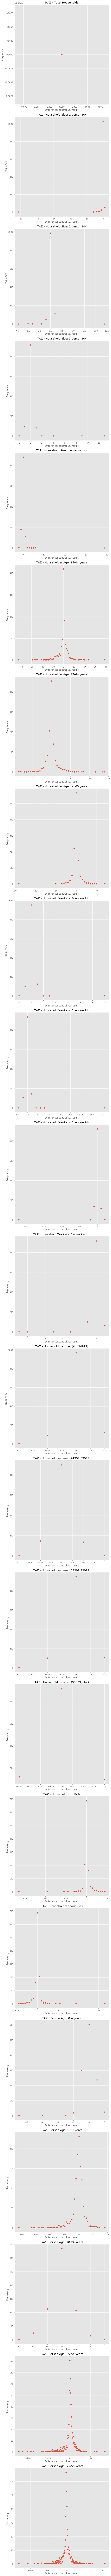

In [25]:
figure_length = len(aggregate_list)
summary_fig, axes = plt.subplots(figure_length, 1, figsize=(8,8*figure_length))

stats_l = []
for params, ax in zip(aggregate_list, axes):
    stats, frequencies = process_control(**params)
    stats_l.append(stats)
    
    ax.set_title(f"{params['geography']} - {params['name']}")
    ax.set_ylabel('Frequency'); ax.set_xlabel('Difference: control vs. result')
    ax.scatter(frequencies.index, frequencies)

summary_fig.savefig(os.path.join(validation_dir, 'frequencies.pdf'))
stats_df = pd.DataFrame(stats_l)
stats_df.to_csv(os.path.join(validation_dir, f'{scenario}_{region}_popsim_stats.csv'), index=False)

Calculate the standard deviation for each comparison

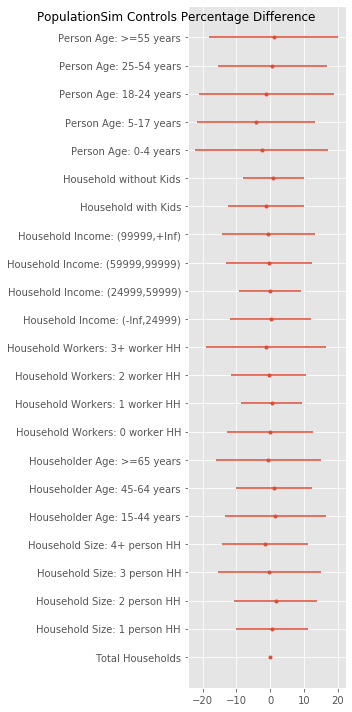

In [784]:
std_fig = plt.figure()
std_fig.suptitle('PopulationSim Controls Percentage Difference')
plt.errorbar(stats_df['mean_pc_difference'],
             stats_df['name'],
             xerr=stats_df['std'],
             linestyle='None',
             marker='.')
std_fig.savefig(os.path.join(validation_dir, f'{scenario}_{region}_popsim_convergence_stdev.pdf'))

## Uniformity
```
seed_cols:
    geog: PUMA
    geog_weight: WGTP
    hh_id: hh_id
```

In [34]:
seed_cols = (seed_hh_cols.values())
geog = seed_hh_cols.get('geog')
geog_weight = seed_hh_cols.get('geog_weight')
hh_id = seed_hh_cols.get('hh_id')

expanded_hhids = pd.read_csv(os.path.join(popsim_dir, exp_hh_file), usecols=[exp_hh_id_col])
seed_hh_df = pd.read_csv(os.path.join(popsim_dir, seed_hh_file), usecols=seed_cols, index_col=hh_id)

In [42]:
weight_mask = seed_hh_df[geog_weight] > 0
weight = expanded_hhids[exp_hh_id_col].value_counts()[weight_mask]
expansion_factor = (weight/seed_hh_df[geog_weight]).fillna(0)

df = pd.DataFrame({
    geog: seed_hh_df[geog],
    geog_weight: seed_hh_df[geog_weight],
    'weight': weight,
    'ef': expansion_factor,
})

geog_group = df.groupby(geog)
geog_final_weight = geog_group.sum()['weight']
expansion = geog_final_weight/geog_group.sum()[geog_weight]

expansion.name = 'avg_expansion'
df = df.join(expansion, on=geog)
df['diff_sq'] = (df['avg_expansion'] - df['ef']) ** 2
rmse = df.groupby(geog).mean()['diff_sq'] ** 0.5

uniformity_df = pd.DataFrame({
    'W': geog_group.sum()[geog_weight],
    'Z': geog_group.sum()['weight'],
    'N': geog_group.count()[geog_weight],
    'EXP': expansion,
    'EXP_MIN': geog_group.min()['ef'],
    'EXP_MAX': geog_group.max()['ef'],
    'RMSE': rmse, 
})

uniformity_df.to_csv(os.path.join(validation_dir, 'uniformity.csv'))
uniformity_df

,W,Z,N,EXP,EXP_MIN,EXP_MAX,RMSE
PUMA,,,,,,,
610701,45696,46581.0,1769,1.019367,0.0,18.444444,1.729442
610702,44546,44300.0,2428,0.994478,0.0,23.362500,1.893785
610703,44902,43731.0,2759,0.973921,0.0,39.241379,2.073778


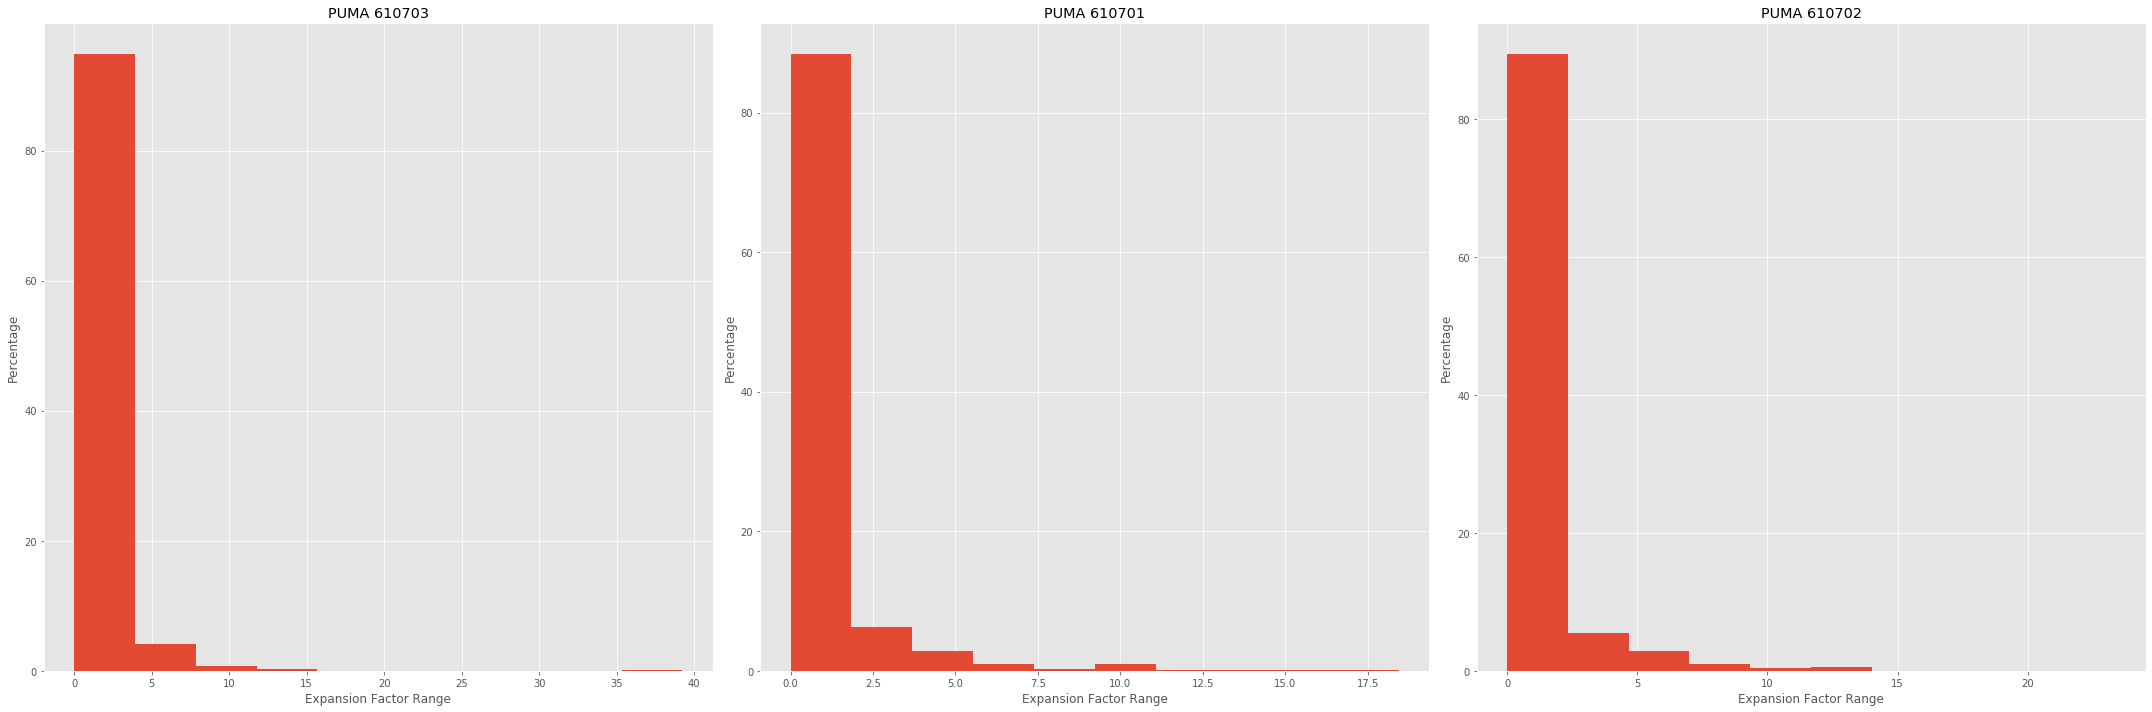

In [44]:
geogs = df[geog].unique()
geog_fig = plt.figure(figsize=(10*len(geogs), 10))

for i, g in enumerate(geogs):
    geog_df = df[df[geog] == g]
    counts, bins = np.histogram(geog_df['ef'])
    ax = geog_fig.add_subplot(1, len(geogs), i+1)
    ax.set_title(f'{geog} {g}')
    ax.set_ylabel('Percentage'); ax.set_xlabel('Expansion Factor Range')
    ax.hist(bins[:-1], bins, weights=counts*100/len(geog_df))